In [1]:
from lsst.daf.persistence import Butler
import astropy.table
import os, sys, time
import random
import pandas as pd
import numpy as np
import csv
import itertools
from collections import Counter
import treecorr
from astropy.io import ascii, fits
from diagnose import plot_XY
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from helper import plot_XY

In [3]:
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=False #True
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=False # True
matplotlib.rcParams['legend.fontsize']=14
matplotlib.rcParams['legend.numpoints']=1
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['legend.handlelength']=0.
matplotlib.rcParams['xtick.minor.visible']=True
matplotlib.rcParams['ytick.minor.visible']=True
matplotlib.rcParams['ytick.direction']='inout'
matplotlib.rcParams['xtick.direction']='inout'
if matplotlib.rcParams['xtick.direction']=='inout':
    matplotlib.rcParams['xtick.major.size']=2.*matplotlib.rcParams['xtick.major.size']
    matplotlib.rcParams['xtick.minor.size']=2.*matplotlib.rcParams['xtick.minor.size']
if matplotlib.rcParams['ytick.direction']=='inout':
    matplotlib.rcParams['ytick.major.size']=2.*matplotlib.rcParams['ytick.major.size']
    matplotlib.rcParams['ytick.minor.size']=2.*matplotlib.rcParams['ytick.minor.size']
matplotlib.rcParams['figure.subplot.bottom']=0.1
matplotlib.rcParams['figure.subplot.top']=0.95
matplotlib.rcParams['figure.subplot.right']=0.95
matplotlib.rcParams['figure.subplot.left']=0.095
matplotlib.rcParams['axes.labelsize']=18
matplotlib.rc('font',size=18)

In [4]:
class E1(object):
    """Function to calculate e1 ellipticity for a given object"""
    def __init__(self, column, unitScale=1.0):
        self.column = column
        self.unitScale = unitScale

    def __call__(self, catalog):
        E1 = ((catalog[self.column + "_xx"] - catalog[self.column + "_yy"])/
                 (catalog[self.column + "_xx"] + catalog[self.column + "_yy"]))
        return np.array(E1)*self.unitScale

class E2(object):
    """Function to calculate e2 ellipticity for a given object"""
    def __init__(self, column, unitScale=1.0):
        self.column = column
        self.unitScale = unitScale

    def __call__(self, catalog):
        E2 = (2.0*catalog[self.column + "_xy"]/
                 (catalog[self.column + "_xx"] + catalog[self.column + "_yy"]))
        return np.array(E2)*self.unitScale

class E1Resids(object):
    """Functor to calculate e1 ellipticity residuals for a given object and psf model"""
    def __init__(self, column, psfColumn, unitScale=1.0):
        self.column = column
        self.psfColumn = psfColumn
        self.unitScale = unitScale

    def __call__(self, catalog):
        srcE1func = E1(self.column, self.unitScale)
        psfE1func = E1(self.psfColumn, self.unitScale)

        srcE1 = srcE1func(catalog)
        psfE1 = psfE1func(catalog)

        e1Resids = srcE1 - psfE1
        return e1Resids


class E2Resids(object):
    """Functor to calculate e2 ellipticity residuals for a given object and psf model"""
    def __init__(self, column, psfColumn, unitScale=1.0):
        self.column = column
        self.psfColumn = psfColumn
        self.unitScale = unitScale

    def __call__(self, catalog):
        srcE2func = E2(self.column, self.unitScale)
        psfE2func = E2(self.psfColumn, self.unitScale)

        srcE2 = srcE2func(catalog)
        psfE2 = psfE2func(catalog)

        e2Resids = srcE2 - psfE2
        return e2Resids

    
class PsfTraceSizeDiff(object):
    """Functor to calculate trace radius size difference (%) between object and psf model"""
    def __init__(self, column, psfColumn):
        self.column = column
        self.psfColumn = psfColumn

    def __call__(self, catalog):
        srcSize = np.sqrt(0.5*(catalog[self.column + "_xx"] + catalog[self.column + "_yy"]))
        psfSize = np.sqrt(0.5*(catalog[self.psfColumn + "_xx"] + catalog[self.psfColumn + "_yy"]))
        sizeDiff = 100*(srcSize - psfSize)/(0.5*(srcSize + psfSize))
        return np.array(sizeDiff)

In [5]:
new_visit_star_catalog = pd.read_parquet('visit_star_catalog.parq')

In [6]:
visit_star_catalog_badseeing = pd.read_parquet('visit_star_catalog_badseeing.parq')

In [7]:
new_tract_star_catalog = pd.read_parquet('tract_star_catalog.parq')

In [8]:
my_tract_star_catalog = pd.read_parquet('tract_star_catalog2.parq')

In [9]:
pdr2 = fits.open('pdr2.fits')[1].data
print(pdr2.names)

['object_id', 'object_id_isnull', 'i_ra', 'i_ra_isnull', 'i_dec', 'i_dec_isnull', 'skymap_id', 'skymap_id_isnull', 'tract', 'tract_isnull', 'patch', 'patch_isnull', 'i_psfflux_mag', 'i_psfflux_mag_isnull', 'i_psfflux_magsigma', 'i_psfflux_magsigma_isnull', 'i_sdssshape_shape11', 'i_sdssshape_shape11_isnull', 'i_sdssshape_shape22', 'i_sdssshape_shape22_isnull', 'i_sdssshape_shape12', 'i_sdssshape_shape12_isnull', 'i_sdssshape_psf_shape11', 'i_sdssshape_psf_shape11_isnull', 'i_sdssshape_psf_shape22', 'i_sdssshape_psf_shape22_isnull', 'i_sdssshape_psf_shape12', 'i_sdssshape_psf_shape12_isnull', 'i_sdssshape_flag', 'i_sdssshape_flag_isnull', 'i_sdssshape_flag_psf', 'i_sdssshape_flag_psf_isnull', 'i_sdssshape_flag_badcentroid', 'i_sdssshape_flag_badcentroid_isnull', 'i_calib_psfcandidate', 'i_calib_psfcandidate_isnull', 'i_calib_psfused', 'i_calib_psfused_isnull', 'i_pixelflags_edge', 'i_pixelflags_edge_isnull', 'i_pixelflags_interpolated', 'i_pixelflags_interpolated_isnull', 'i_pixelflags_

In [10]:
## Boiler plate code

def getStarCatalog(tracts=[9813,9615,9697], filt='HSC-I'):
    t1 = time.time()
    good_data_list = []
    all_patches = ['{},{}'.format(i,j) for i,j in list(itertools.product(range(9),range(9)))]
    butler = Butler('/datasets/hsc/repo/rerun/RC/w_2019_38/DM-21386/')
    for tract in tracts:
        for patch in all_patches:
            dataId = {'tract':tract, 'patch':patch, 'filter':filt}
            try:
                data = butler.get('deepCoadd_meas', dataId)
            except:
                print("Carson could not fetch ", dataId)
                continue
        
            bad = np.zeros(len(data), dtype=bool)
            #bad |= (data['calib_psf_used']==False)
            bad |= (data['base_ClassificationExtendedness_value'] >= 0.5) 
            #bad |= data["deblend_nChild"] > 0
        
            good_data = data[~bad].copy(deep=True)
            good_data_list.append(good_data.asAstropy())
    
    good_data = astropy.table.vstack(good_data_list)
    t2 = time.time()
    print("Data fetched in %.2f seconds" % (t2-t1))
    return good_data
    
def myButler(tracts=[9615,9697,9813], visits=False, filter='HSC-I'):
    good_data_list = [ ]
    for tract in tracts:
        if visits:
            visit_dirs = os.listdir('/datasets/hsc/repo/rerun/RC/w_2019_38/DM-21386/plots/{1}/tract-{0}/'.format(tract,filter))
            visit_data_list = []
            for visit_dir in visit_dirs:
                if not 'visit-' in visit_dir: continue
                visit_id = visit_dir.split('-')[1]
                data = pd.read_parquet('/datasets/hsc/repo/rerun/RC/w_2019_38/DM-21386/plots/{1}/tract-{0}/'.format(tract,filter)+visit_dir+'/{0}_{1}_commonZp.parq'.format(tract,visit_id))
                visit_data_list.append(data)
            data = pd.concat(visit_data_list)
        else:
            data = pd.read_parquet('/datasets/hsc/repo/rerun/RC/w_2019_38/DM-21386/plots/{1}/tract-{0}/{0}_unforced.parq'.format(tract, filter))
        bad = np.zeros(len(data), dtype=bool)
        #bad |= (data['calib_psf_used']==False)
        bad |= (data['base_ClassificationExtendedness_value'] >= 0.5) 
        #bad |= data["deblend_nChild"] > 0
        print(len(bad)-bad.sum())
        #for flag in flags:
        #    bad |= data[flag]
        #print(len(bad)-bad.sum())
        good_data = data[~bad].copy(deep=True)
        good_data_list.append(good_data)
        
    good_data = pd.concat(good_data_list)
    return good_data

def corr2(ra, dec, g1a, g2a, g1b, g2b, ra_units="degrees", dec_units="degrees", **treecorr_kwargs):
    """ Function to compute auto-/cross-correlations between atmost two shear fields.

        This is used to compute Rowe statistics, given the appropriate 'shear' fields.
    """

    xy = treecorr.GGCorrelation(**treecorr_kwargs)
    catA = treecorr.Catalog(ra=ra, dec=dec, g1=g1a, g2=g2a, ra_units="degrees",
                               dec_units="degrees")
    if g1b is None or g2b is None:
        # Calculate the auto-correlation
        xy.process(catA)
    else:
        catB = treecorr.Catalog(ra=ra, dec=dec, g1=g1b, g2=g2b, ra_units="degrees",
                               dec_units="degrees")
        # Calculate the cross-correlation
        xy.process(catA, catB)

    return xy
   
class RhoStatistics(object):
    """Functor to calculate Rho statistics for a given star catalog and psf model"""
    def __init__(self, column, psfColumn, **kwargs):
        self.column = column
        self.psfColumn = psfColumn
        
        self.e1Func = E1(self.psfColumn)
        self.e2Func = E2(self.psfColumn)
        self.e1ResidsFunc = E1Resids(self.column, self.psfColumn)
        self.e2ResidsFunc = E2Resids(self.column, self.psfColumn)
        self.SizeResidsFunc = PsfTraceSizeDiff(self.column, self.psfColumn) # output will be in percentage

        self.treecorr_kwargs = {'nbins':kwargs.get('nbins',20), 
                        'min_sep':kwargs.get('min_sep',0.05), 
                        'max_sep':kwargs.get('max_sep',1), 
                        'sep_units':kwargs.get('sep_units',"degrees"), 
                        'verbose':kwargs.get('verbose',0)}

    def __call__(self, catalog, fname=None):
        e1 = self.e1Func(catalog)
        e2 = self.e2Func(catalog)
        e1Res = self.e1ResidsFunc(catalog)
        e2Res = self.e2ResidsFunc(catalog)
        SizeRes = self.SizeResidsFunc(catalog)/100. # since output is in percentage

        isFinite = np.isfinite(e1Res) & np.isfinite(e2Res) & np.isfinite(SizeRes)
        e1 = e1[isFinite]
        e2 = e2[isFinite]
        e1Res = e1Res[isFinite]
        e2Res = e2Res[isFinite]
        SizeRes = SizeRes[isFinite]

        # Scale the SizeRes by ellipticities
        e1SizeRes = e1*SizeRes
        e2SizeRes = e2*SizeRes

        #e1Res = 0.5*np.random.randn(len(e1Res))
        #e2Res = 0.5*np.random.randn(len(e2Res))

        # Package the arguments to capture auto-/cross-correlations for Rowe statistics
        g_args = {1: (e1Res, e2Res, None, None),
                  2: (e1, e2, e1Res, e2Res),
                  3: (e1SizeRes, e2SizeRes, None, None),
                  4: (e1Res, e2Res, e1SizeRes, e2SizeRes),
                  5: (e1, e2, e1SizeRes, e2SizeRes) }

        ra = np.rad2deg(catalog["coord_ra"][isFinite])
        dec = np.rad2deg(catalog["coord_dec"][isFinite])
 
        radii = dict.fromkeys(range(1,6))
        xip = dict.fromkeys(range(1,6))
        xipErr = dict.fromkeys(range(1,6))
        ret = dict.fromkeys(range(1,6))

        # Pass the appropriate arguments to the correlator
        for rhoIndex in range(1,6):
            # RFC: Should I just implement the corr2 functionality here inline?
            xy = corr2(ra, dec, *(g_args[rhoIndex]), ra_units="degrees", dec_units="degrees", **self.treecorr_kwargs)
            radii[rhoIndex] = np.exp(xy.meanlogr)
            xip[rhoIndex] = xy.xip
            xipErr[rhoIndex] = np.sqrt(xy.varxi)
            ret[rhoIndex] = xy
            
            if fname is not None:
                xy.write('rho{0}_'.format(rhoIndex)+fname)

        return ret

In [4]:
np.logical_and(False, np.array([0,1,0,1,0,1],dtype=bool))

array([False, False, False, False, False, False])

In [11]:
def sgn(x):
    ret = 1 if x>0 else -1
    return ret

def plot2(fnames, axes, xscale='log', yscale='symlog', title=None, marker='o', labels=None):
    linthresy_dict = {1: 1e-7, 2:1e-6, 3:1e-8, 4:1e-8, 5:1e-7}
    for rhoIndex in range(1,6):
        ax = axes[rhoIndex-1]
        for fid, fname in enumerate(fnames):
            rhoStats = ascii.read('rho{}_'.format(rhoIndex)+fname)
            colorStr = "C{}".format(fid) # + str(np.mod(iTract, 9))
            ax.errorbar(rhoStats['meanR'], rhoStats['xip'], yerr=rhoStats['sigma_xi'], color=colorStr,
                    fmt=marker, label=labels[fid])

        ax.set_xscale(xscale)
        ax.set_ylabel(r"$\rho_{0}(\theta)$".format(rhoIndex))
        ax.set_xlabel(r'$\theta$ (degrees)')
        ax.set_title(title)
        
        if 'log' in yscale:
            ymin, ymax = ax.get_ylim()
            logymin, logymax = np.floor(np.log10(np.abs(ymin))), np.ceil(np.log10(np.abs(ymax)))
            if np.any((rhoStats['xip']-rhoStats['sigma_xi'])<0) and np.any((rhoStats['xip']+rhoStats['sigma_xi'])>0):
                linthresy = linthresy_dict[rhoIndex]
                ax.set_yscale('symlog', linthreshy=linthresy)

                yticks =  (sgn(ymin)*10**np.arange(logymin, np.floor(np.log10(linthresy)),1)).tolist() \
                      + (np.linspace(-1,1,9)*linthresy).tolist() \
                      + (10**np.arange(np.ceil(np.log10(linthresy)),logymax+1, 1)).tolist()
                ax.axhspan(-linthresy,linthresy,color='k',alpha=0.2)
            else:
                yticks = sgn(ymax)*10**(np.arange(logymin, logymax+1,1))
                ax.set_yscale('symlog')
            
            print(rhoIndex, yticks)          
            ax.set_yticks(yticks, minor=True)
        else:
            ax.set_yscale(yscale)
            ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

        ax.axhline(0.0, color='k', ls='--')
        ax.legend(loc='best')
            

def plot(fname, axes, xscale='log', yscale='log', title=None, **plotKwargs):
    for rhoIndex in range(1,6):
        rhoStats = ascii.read('rho{}_'.format(rhoIndex)+fname)
        ## The mapping creates plots as in DES papers
        #ax = axes[1] if rhoIndex in [2,5] else axes[0]
        ax = axes[0]
        colorStr = "C{}".format(rhoIndex) # + str(np.mod(iTract, 9))
        isPositive = rhoStats['xip'][rhoIndex]>0
        if yscale=='symlog':
            ax.errorbar(rhoStats['meanR'], rhoStats['xip'], yerr=rhoStats['sigma_xi'], color=colorStr,
                    fmt='o', label=r"$\rho_{0}(\theta)$".format(rhoIndex))
        else:
            ax.errorbar(rhoStats['meanR'][isPositive], rhoStats['xip'][isPositive], yerr=rhoStats['sigma_xi'][isPositive], color=colorStr,
                        fmt='o', label=r"$\rho_{0}(\theta)$".format(rhoIndex))
            ax.errorbar(rhoStats['meanR'][~isPositive], -rhoStats['xip'][~isPositive], yerr=rhoStats['sigma_xi'][~isPositive], color=colorStr,
                        fillstyle='none', label=None, fmt='o')
        
    for ax in axes:
        if yscale=='symlog':
            ax.set_yscale('symlog', linthresy=0.0001)
        else:
            ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        ax.set_ylabel(r'$\rho(\theta)$')
        ax.set_xlabel(r'$\theta$ (degrees)')
        ax.set_title(title)
        ax.legend(loc='best')
        
def plotAll(star_catalog, xscale='log', yscale='log', shape='HSM', title=None, marker='o', label_suffix='', figax=None, from_scratch=True):
    
    fnames = ['psfStars_'+shape, 'nonPsfStars1_'+shape, 'nonPsfStars2_'+shape]
    labels = [lab+label_suffix for lab in ['PSF stars', 'Non-PSF all stars', 'Non-PSF good stars']]

    if from_scratch:
        if shape=='HSM':
            compareCol = 'ext_shapeHSM_HsmSourceMoments'
            psfCompareCol = 'ext_shapeHSM_HsmPsfMoments'
        else:
            compareCol = 'base_SdssShape'
            psfCompareCol = 'base_SdssShape_psf'

        rhoStatsFunc = RhoStatistics(compareCol, psfCompareCol)
        
        if 'base_PsfFlux_instFlux' in star_catalog.columns:
            faint_stars = -2.5*np.log10(star_catalog['base_PsfFlux_instFlux']) > -3.5
        elif 'imag_psf' in star_catalog.columns:
            faint_stars = star_catalog['imag_psf'] >= 22.5
        else:
            faint_stars = False

        omit = star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | faint_stars
        omit = omit | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid']
        star_catalog = star_catalog[~omit]

        cuts_dict = {0: star_catalog['calib_psf_used']==1,\
                     1: ~(star_catalog['calib_psf_used'] | (star_catalog['base_ClassificationExtendedness_value']!=0) | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid']),\
                     2: ~(star_catalog['calib_psf_used'] | (star_catalog['base_ClassificationExtendedness_value']!=0) | star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])
                    }

        for fid, fname in enumerate(fnames):
            cuts = cuts_dict[fid]
            print(cuts.sum())
            input_catalog = star_catalog[cuts]
            rhoStats = rhoStatsFunc(input_catalog, fname=fname)
    
    if figax is None:
        fig5, ax5 = plt.subplots(1,5)
        fig5.set_size_inches([30,6])
    else:
        fig5, ax5 = figax
    
    plot2(fnames[:2], ax5, xscale=xscale, yscale=yscale, title=title, labels=labels, marker=marker)
    fig5.tight_layout()
    return fig5, ax5
        
    if False:    
        ## PSF stars only
        fig, ax = plt.subplots()
        axes = [ax]
        fname = 'psfStars_'+shape
        if from_scratch:
            cuts = star_catalog['calib_psf_used']==1
            input_catalog = star_catalog[cuts]
            rhoStats = rhoStatsFunc(input_catalog, fname=fname)
        plot(fname, axes, xscale=xscale, yscale=yscale, title=title)

        ## Non-psf-stars (strict)
        fig, ax = plt.subplots()
        axes = [ax]
        fname = 'nonPsfStars1_'+shape
        if from_scratch:
            cuts = (star_catalog['calib_psf_used']==0)&(star_catalog['base_ClassificationExtendedness_value']==0)
            input_catalog = star_catalog[cuts]
            rhoStats = rhoStatsFunc(input_catalog, fname=fname)
        plot(fname, axes, xscale=xscale, yscale=yscale, title=title)

        ## Non-psf_stars (loose)
        fig, ax = plt.subplots()
        axes = [ax]
        fname = 'nonPsfStars2_'+shape
        if from_scratch:
            cuts = (star_catalog['base_ClassificationExtendedness_value']<0.5)
            input_catalog = star_catalog[cuts]
            rhoStats = rhoStatsFunc(input_catalog, fname=fname)
        plot(fname, axes, xscale=xscale, yscale=yscale, title=title)
    
    

In [12]:
## Basic plots

def histEresids(star_catalog, bins = np.linspace(-0.05,0.05,51), weights=None, label=None, color='C0', figax=None):
    diff_g1 = E1Resids(column='ext_shapeHSM_HsmSourceMoments', psfColumn='ext_shapeHSM_HsmPsfMoments', unitScale=0.5)(star_catalog)#/E1(column='ext_shapeHSM_HsmPsfMoments', unitScale=0.5)(star_catalog)
    diff_g2 = E2Resids(column='ext_shapeHSM_HsmSourceMoments', psfColumn='ext_shapeHSM_HsmPsfMoments', unitScale=0.5)(star_catalog)#/E2(column='ext_shapeHSM_HsmPsfMoments', unitScale=0.5)(star_catalog)
    if figax is None:
        fig, ax = plt.subplots(1,2)
    else:
        fig, ax = figax
    ax[0].hist(diff_g1, histtype='step', bins=bins, density=True, weights=weights, label=None, color=color)
    ax[1].hist(diff_g2, histtype='step', bins=bins, density=True, weights=weights, label=label, color=color)
    ax[0].axvline(0.0, color='k'); ax[1].axvline(0.0, color='k')
    ax[0].set_xlabel(r'$g_1^*-g_1^{PSF}$')
    ax[1].set_xlabel(r'$g_2^*-g_2^{PSF}$')
    ax[1].legend(loc='best')

In [13]:

renaming = {'ira':'coord_ra', 'idec':'coord_dec',
              'ishape_hsm_moments_11':'ext_shapeHSM_HsmSourceMoments_xx',
              'ishape_hsm_moments_22':'ext_shapeHSM_HsmSourceMoments_yy',
              'ishape_hsm_moments_12':'ext_shapeHSM_HsmSourceMoments_xy',
              'ishape_hsm_psfmoments_11':'ext_shapeHSM_HsmPsfMoments_xx',
              'ishape_hsm_psfmoments_22':'ext_shapeHSM_HsmPsfMoments_yy',
              'ishape_hsm_psfmoments_12':'ext_shapeHSM_HsmPsfMoments_xy',
              'ishape_sdss_11':'base_SdssShape_xx',
              'ishape_sdss_22':'base_SdssShape_yy',
              'ishape_sdss_12':'base_SdssShape_xy',
              'ishape_sdss_psf_11':'base_SdssShape_psf_xx',
              'ishape_sdss_psf_22':'base_SdssShape_psf_yy',
              'ishape_sdss_psf_12':'base_SdssShape_psf_xy',
              'ishape_sdss_flags':'base_SdssShape_flag',
              'ishape_sdss_flags_psf':'base_SdssShape_flag_psf',
              'iflags_badcentroid':'base_PixelFlags_flag_badCentroid',
               'base_PixelFlags_flag_badCentroid':'base_PsfFlux_flag_badCentroid',
              'iflags_pixel_interpolated_any':'base_PixelFlags_flag_interpolated',
              'iflags_pixel_saturated_any':'base_PixelFlags_flag_saturated',
              'iflags_pixel_cr_any':'base_PixelFlags_flag_cr',
              'ishape_hsm_moments_flags':'ext_shapeHSM_HsmSourceMoments_flag',
              'ishape_hsm_psfmoments_flags':'ext_shapeHSM_HsmPsfMoments_flag',
              'ishape_hsm_moments_centroid_flags':'ext_shapeHSM_HsmSourceMoments_flag_badCentroid',
              'ishape_hsm_psfmoments_centroid_flags':'ext_shapeHSM_HsmPsfMoments_flag_badCentroid',
              'iclassification_extendedness':'base_ClassificationExtendedness_value',
              'icalib_psf_used':'calib_psf_used','iflags_pixel_edge':'base_PixelFlags_flag_edge',
              'iflags_pixel_suspect_any':'base_PixelFlags_flag_suspect',
              }
s16a_wide2 = fits.open('/datasets/hsc/repo/rerun/private/kannawad/pdr1/s16a_wide_stars2.fits')[1].data
for orig_colname, new_colname in renaming.items():
    s16a_wide2.columns[orig_colname] = new_colname
#s16a_wide.rename(columns=renaming, inplace=True)
    #omit = star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] 
    #omit |= star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid']
#s16a_wide['calib_psf_reserved'] = pd.Series(s16a_wide['calib_psf_used'], index=s16a_wide.index)

TypeError: 'ColDefs' object does not support item assignment

In [16]:
star_catalog = s16a_wide

omit = (star_catalog['calib_psf_used'] | (star_catalog['base_ClassificationExtendedness_value']!=0) | star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])
omit |= star_catalog['iflags_pixel_clipped_any'] | star_catalog['iflags_pixel_edge'] | star_catalog['iflags_negative'] | star_catalog['iflags_badcentroid'] | star_catalog['iflags_pixel_suspect_any']
cuts = ~omit
cuts = star_catalog['icalib_psf_candidate']==1
histEresids(s16a_wide[cuts])

KeyError: "Key 'calib_psf_used' does not exist."

In [15]:
s16a_wide = s16a_wide2

In [17]:
dtype_dicts = {'calib_psf_used':bool, 'base_PixelFlags_flag_interpolated':bool, 'base_PixelFlags_flag_cr':bool,
               'base_PixelFlags_flag_saturated':bool, 'ext_shapeHSM_HsmSourceMoments_flag_badCentroid':bool, 'ext_shapeHSM_HsmSourceMoments_flag':bool,
               'ext_shapeHSM_HsmPsfMoments_flag':bool, 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid':bool, 'base_PixelFlags_flag_clipped':bool,
               'base_PixelFlags_flag_edge':bool, 'base_PsfFlux_flag_badCentroid':bool, 'base_PixelFlags_flag_suspect':bool,
               'calib_psf_reserved':bool}
new_tract_star_catalog.column

AttributeError: 'DataFrame' object has no attribute 'column'

In [18]:
def plotBasics(star_catalog, nonPSF=True, random_subset_frac=1.0):
    if random_subset_frac<1.0 and random_subset_frac>0.0:
        star_catalog = star_catalog.sample(frac=random_subset_frac)
        
    column = 'ext_shapeHSM_HsmSourceMoments'
    psfColumn = 'ext_shapeHSM_HsmPsfMoments'
        
    omit = (star_catalog['base_ClassificationExtendedness_value']!=0)
    if 'base_PixelFlags_flag_clipped' in star_catalog.columns:
        omit |= star_catalog['base_PixelFlags_flag_clipped']
    omit |= (star_catalog['calib_psf_used'] | star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])
    omit |= star_catalog['base_PixelFlags_flag_edge'] | star_catalog['base_PsfFlux_flag_badCentroid'] | star_catalog['base_PixelFlags_flag_suspect']
    if nonPSF:
        if 'base_PsfFlux_instFlux' in star_catalog.columns:
            omit |= -2.5*np.log10(star_catalog['base_PsfFlux_instFlux'])>(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][star_catalog['calib_psf_used']==1])).max()
        else:
            omit |= star_catalog['imag_psf']>22.5
    cuts = ~omit

    print("No. of PSF stars: ", star_catalog['calib_psf_used'].sum())
    print("No. of non-PSF stars: ", cuts.sum())
    
    fig, ax = plt.subplots(1,2)

    histEresids(star_catalog[star_catalog['calib_psf_used']], figax=(fig,ax), label='PSF stars', color='C0')
    histEresids(star_catalog[star_catalog['calib_psf_reserved']], figax=(fig,ax), label='Reserved stars', color='C1')
    if nonPSF:
        histEresids(star_catalog[cuts], figax=(fig,ax), label='Non-PSF stars', color='C2')
    if 'base_PixelFlags_flag_inexact_psf' in star_catalog.columns:
        histEresids(star_catalog[(star_catalog['calib_psf_used'] & star_catalog['base_PixelFlags_flag_inexact_psf'])], figax=(fig,ax), label='PSF stars (INEXACT_PSF)', color='C3')
        histEresids(star_catalog[(star_catalog['calib_psf_used'] & ~star_catalog['base_PixelFlags_flag_inexact_psf'])], figax=(fig,ax), label='PSF stars (EXACT_PSF)', color='C4')

    fig, ax = plt.subplots()
    sizeDiff = PsfTraceSizeDiff(column=column, psfColumn=psfColumn)(star_catalog[star_catalog['calib_psf_used']])
    _n, _bins, _patches = plt.hist(0.01*sizeDiff, histtype='step', density=True, bins=np.linspace(-0.05,0.05,101), color='C0', label='PSF stars')
    sizeDiff = PsfTraceSizeDiff(column=column, psfColumn=psfColumn)(star_catalog[star_catalog['calib_psf_reserved']])
    _n, _bins, _patches = plt.hist(0.01*sizeDiff, histtype='step', density=True, bins=np.linspace(-0.05,0.05,101), color='C1', label='Reserved stars')
    if nonPSF:
        sizeDiff = PsfTraceSizeDiff(column=column, psfColumn=psfColumn)(star_catalog[cuts])
        _n, _bins, _patches = plt.hist(0.01*sizeDiff, histtype='step', density=True, bins=np.linspace(-0.05,0.05,101), color='C2', label='Non-PSF stars')
    if 'base_PixelFlags_flag_inexact_psf' in star_catalog.columns:
        sizeDiff = PsfTraceSizeDiff(column=column, psfColumn=psfColumn)(star_catalog[(star_catalog['calib_psf_used'] & star_catalog['base_PixelFlags_flag_inexact_psf'])])
        _n, _bins, _patches = plt.hist(0.01*sizeDiff, histtype='step', density=True, bins=np.linspace(-0.05,0.05,101), color='C0', label='PSF stars (INEXACT PSF)')
        sizeDiff = PsfTraceSizeDiff(column=column, psfColumn=psfColumn)(star_catalog[(star_catalog['calib_psf_used'] & ~star_catalog['base_PixelFlags_flag_inexact_psf'])])
        _n, _bins, _patches = plt.hist(0.01*sizeDiff, histtype='step', density=True, bins=np.linspace(-0.05,0.05,101), color='C0', label='PSF stars (EXACT PSF)')
    ax.axvline(0.0, color='k')
    ax.legend(loc=2)
    ax.set_xlabel(r'$\frac{\sigma_*-\sigma_{psf}}{(\sigma_*+\sigma_{psf})/2}$')

    fig,ax = plt.subplots()
    _n, _bins, _patches = ax.hist(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][star_catalog['calib_psf_used']]), histtype='step', density=True, label='PSF stars')
    _n, _bins, _patches = ax.hist(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][star_catalog['calib_psf_reserved']]), histtype='step', density=True, label='Reserved stars')
    _n, _bins, _patches = ax.hist(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][star_catalog['calib_psf_candidate']]), histtype='step', density=True, label='Candidate stars')
    if nonPSF:
        _n, _bins, _patches = ax.hist(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][cuts]), histtype='step', density=True, label='Non-PSF stars')
    ax.legend(loc='best')
    ax.set_xlabel(r'$-2.5\log_{10}$(base_PsfFlux_instFlux)')

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


No. of PSF stars:  855794
No. of non-PSF stars:  1010574


/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


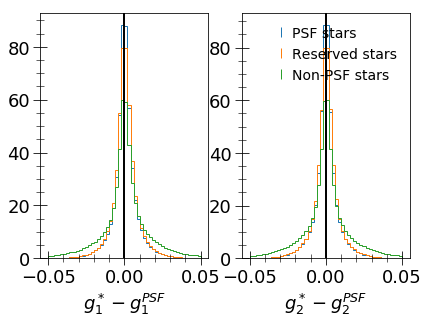

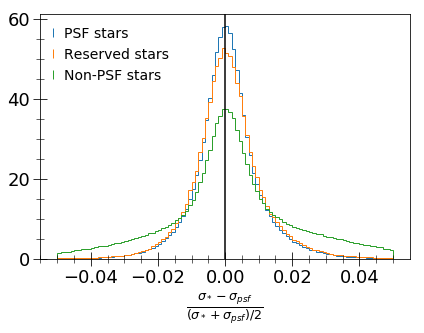

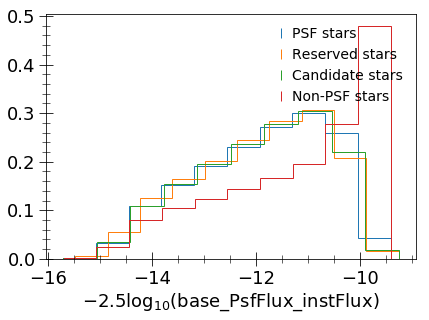

In [19]:
plotBasics(new_visit_star_catalog, nonPSF=True)# .to_pandas().astype(dtype_dicts)

No. of PSF stars:  80872
No. of non-PSF stars:  25256


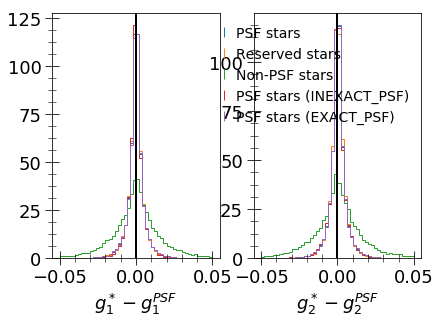

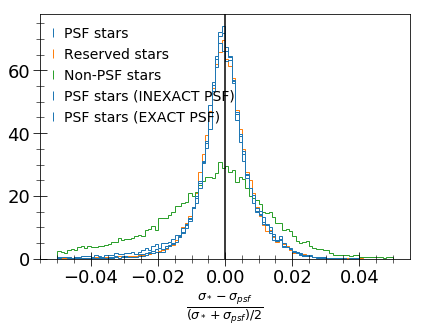

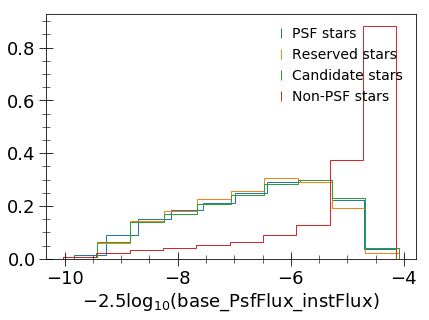

In [20]:
plotBasics(new_tract_star_catalog, nonPSF=True)

In [21]:
#list(s16a_wide.columns)
plotBasics(s16a_wide, nonPSF=False)

KeyError: "Key 'base_ClassificationExtendedness_value' does not exist."

In [22]:
star_catalog = new_visit_star_catalog.to_pandas().astype(dtype_dicts)

omit = (star_catalog['base_ClassificationExtendedness_value']!=0)
omit |= (star_catalog['calib_psf_used'] | star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])
omit |= star_catalog['base_PixelFlags_flag_clipped'] | star_catalog['base_PixelFlags_flag_edge'] | star_catalog['base_PsfFlux_flag_badCentroid'] | star_catalog['base_PixelFlags_flag_suspect']
omit |= -2.5*np.log10(star_catalog['base_PsfFlux_instFlux'])>(-2.5*np.log10(star_catalog['base_PsfFlux_instFlux'][star_catalog['calib_psf_used']==1])).max()
cuts = ~omit

fig, ax = plt.subplots(1,2)
#histEresids(star_catalog[cuts], figax=(fig,ax), label='Non-PSF stars', color='C0')
histEresids(star_catalog[star_catalog['calib_psf_used']], figax=(fig,ax), label='PSF stars', color='C1')
histEresids(star_catalog[star_catalog['calib_psf_reserved']], figax=(fig,ax), label='Reserved stars', color='C2')

fig, ax = plt.subplots()
sizeDiff = PsfTraceSizeDiff(column='ext_shapeHSM_HsmSourceMoments', psfColumn='ext_shapeHSM_HsmPsfMoments')(star_catalog[star_catalog['calib_psf_used']])
_n, _bins, _patches = plt.hist(sizeDiff, bins=np.linspace(-0.5,0.5,101))

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [23]:
s16a_wide['calib_psf_used']

KeyError: "Key 'calib_psf_used' does not exist."

KeyError: 'iflags_pixel_edge'

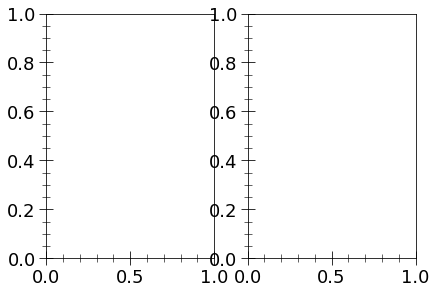

In [24]:
fields = ['gama09h','gama15h','xmm','hectomap','vvds']
dirname = '/datasets/hsc/repo/rerun/private/kannawad/pdr1/'
fig, ax = plt.subplots(1,2)
for field_id, field  in enumerate(fields):
    star_catalog = pd.read_csv(os.path.join(dirname,field+'.csv'))
    star_catalog.rename(columns=renaming, inplace=True)
    omit = (star_catalog['calib_psf_used'] | (star_catalog['base_ClassificationExtendedness_value']!=0) | star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])
    omit |= star_catalog['iflags_pixel_clipped_any'] | star_catalog['iflags_pixel_edge'] | star_catalog['iflags_negative'] | star_catalog['iflags_badcentroid'] | star_catalog['iflags_pixel_suspect_any']
    omit |= star_catalog['imag_psf']>22.5
    cuts = ~omit
    histEresids(star_catalog[cuts], label=field, color='C{}'.format(field_id), figax=(fig,ax))
    

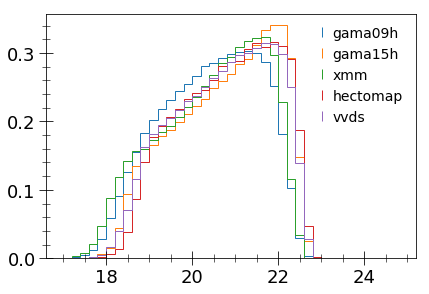

In [25]:
fields = ['gama09h','gama15h','xmm','hectomap','vvds']
dirname = '/datasets/hsc/repo/rerun/private/kannawad/pdr1/'
fig, ax = plt.subplots()
bins = np.arange(17,25,0.2)
for field_id, field  in enumerate(fields):
    star_catalog = pd.read_csv(os.path.join(dirname,field+'.csv'))
    star_catalog.rename(columns=renaming, inplace=True)
    cuts = star_catalog['calib_psf_used']
    plt.hist(star_catalog[cuts]['imag_psf'], bins=bins, histtype='step', color='C{}'.format(field_id), density=True, label=field)
plt.legend(loc='best')

In [26]:
y1 = -2.5*np.log10(tract_star_catalog['base_PsfFlux_instFlux'][tract_star_catalog['calib_psf_used']==1])
y2 = -2.5*np.log10(tract_star_catalog['base_PsfFlux_instFlux'][(tract_star_catalog['calib_psf_used']==0)&(tract_star_catalog['base_ClassificationExtendedness_value']==0)])

plt.hist(y1,histtype='step')
plt.hist(y2,histtype='step')
print(y1.max())

NameError: name 'tract_star_catalog' is not defined

In [30]:
def plot_XY(X_data,Y_data,weight_Y=None, bins=10, bins2=10, figax=None,label=None, color=None, side_histograms=True, normed=True):
    #ipdb.set_trace()
    if side_histograms is False:
        if figax is None:
            fig, ax = plt.subplots()
            figax = (fig,ax)
        else:
            fig,ax = figax
    else: ## side_histogram=True
        if figax is None:
            gs = matplotlib.gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,3],hspace=0.,wspace=0.)
            fig = plt.figure()
            fig.set_size_inches([12,8])
            ax = fig.add_subplot(gs[2])
            ax_top = fig.add_subplot(gs[0], sharex=ax)
            ax_right = fig.add_subplot(gs[3], sharey=ax)
            axes = [ax_top,None,ax,ax_right]
            figax = (fig, axes)
        else:
            fig, axes = figax
            ax_top, none, ax, ax_right = axes

    if isinstance(bins,int):
        nbins = bins
        binedges = np.nanpercentile(X_data,np.linspace(0,100,nbins+1))
    else:
        nbins = len(bins)-1
        binedges = bins
        
    if isinstance(bins2,int):
        nbins2 = bins2
        binedges2 = np.nanpercentile(Y_data, np.linspace(0,100,nbins2+1))
    else:
        nbins2 = len(bins2)-1
        binedges2 = bins2
        
    markers = {'g':'o','b':'s','c':'d','r':'^','m':'+','orange':'x'}

    X, Y, Yerr = [ ], [ ], [ ]
    for nbin in range(nbins):
        bincuts = (X_data>=binedges[nbin])&(X_data<binedges[nbin+1])

        x = np.average(X_data[bincuts])
        wtY = None if weight_Y is None else weight_Y[bincuts]
        #y = np.average(Y_data[bincuts],weights=wtY)
        y = np.nanmean(Y_data[bincuts])
        ## Question: How to compute errors on the weighted mean?
        yerr = Y_data[bincuts].std()/np.sqrt(bincuts.sum()-1)

        X.append(x)
        Y.append(y)
        Yerr.append(yerr)
    #print(X,Y,Yerr)
    mkr = markers[color] if color in markers.keys() else 'h'
    ax.errorbar(X,Y,yerr=Yerr,marker='.',label=label,color=color)
    
    if side_histograms is True:
        _ylim = ax.get_ylim()
        _xlim = ax.get_xlim()
        epsilon_x, epsilon_y = 1e-4, 1e-4
        _n, _bins, _patches = ax_top.hist(X_data,bins=binedges,histtype='step',density=normed, color=color)
        _n, _bins, _patches = ax_right.hist(Y_data,bins=binedges2,histtype='step', orientation='horizontal', density=normed, color=color)
        ax_right.tick_params(labelleft=False, labelright=True, right=True)
        ax_top.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True, top=True, right=True, left=False)

        ax_right.set_ylim(ax.get_ylim()[0]+epsilon_y,ax.get_ylim()[1])
        #ax_right.set_xlim(ax_right.get_xlim()[0]+epsilon_x,ax_right.get_xlim()[1])
        #ax_right.set_ylim(_ylim)
        
        #ax_top.set_xlim(_xlim)
        ax_top.set_xlim(ax_top.get_xlim()[0]+epsilon_x,ax_top.get_xlim()[1])
        #ax_top.set_ylim(ax_top.get_ylim()[0]+epsilon_y,ax_top.get_ylim()[1])

    return figax

We will define `bright_stars` as those that have ```-2.5*log10(base_PsfFlux_instFlux) < -3.5```

In [31]:
## Bob's plot

def plotBob(star_catalog, shape='HSM', bins=10, bins2=10, label=None, figax=None, side_histograms=True):
    try:
        if shape=='HSM':
            column = 'ext_shapeHSM_HsmSourceMoments'
            psfColumn = 'ext_shapeHSM_HsmPsfMoments'
        else:
            column = 'base_SdssShape'
            psfColumn = 'base_SdssShape_psf'
        psfTraceSize = np.sqrt(0.5*(star_catalog[psfColumn+'_xx']+star_catalog[psfColumn+'_yy']))
        diffTraceSize = np.sqrt(0.5*(star_catalog[column+'_xx']+star_catalog[column+'_yy']))/psfTraceSize - 1
        psfFWHM = psfTraceSize*2.354820045*0.168
    except:
        if shape=='HSM':
            try:
                column = 'ishape_hsm_moments'
                psfColumn = 'ishape_hsm_psfmoments'
                psfTraceSize = np.sqrt(0.5*(star_catalog[psfColumn+'_11']+star_catalog[psfColumn+'_22']))
                diffTraceSize = np.sqrt(0.5*(star_catalog[column+'_11']+star_catalog[column+'_22']))/psfTraceSize - 1
            except:
                return figax
        else:
            try: # pdr2
                column = 'i_sdssshape_shape'
                psfColumn = 'i_sdssshape_psf_shape'
                psfTraceSize = np.sqrt(0.5*(star_catalog[psfColumn+'11']+star_catalog[psfColumn+'22']))
                diffTraceSize = np.sqrt(0.5*(star_catalog[column+'11']+star_catalog[column+'22']))/psfTraceSize - 1
            except: ## s16a_wide
                column = 'ishape_sdss'
                psfColumn = 'ishape_sdss_psf'
                psfTraceSize = np.sqrt(0.5*(star_catalog[psfColumn+'_11']+star_catalog[psfColumn+'_22']))
                diffTraceSize = np.sqrt(0.5*(star_catalog[column+'_11']+star_catalog[column+'_22']))/psfTraceSize - 1
                
        psfFWHM = psfTraceSize*2.354820045
    
    figax = plot_XY(X_data=psfFWHM, Y_data=diffTraceSize, bins=bins, bins2=bins2, figax=figax, label=label, side_histograms=side_histograms)
    return figax

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


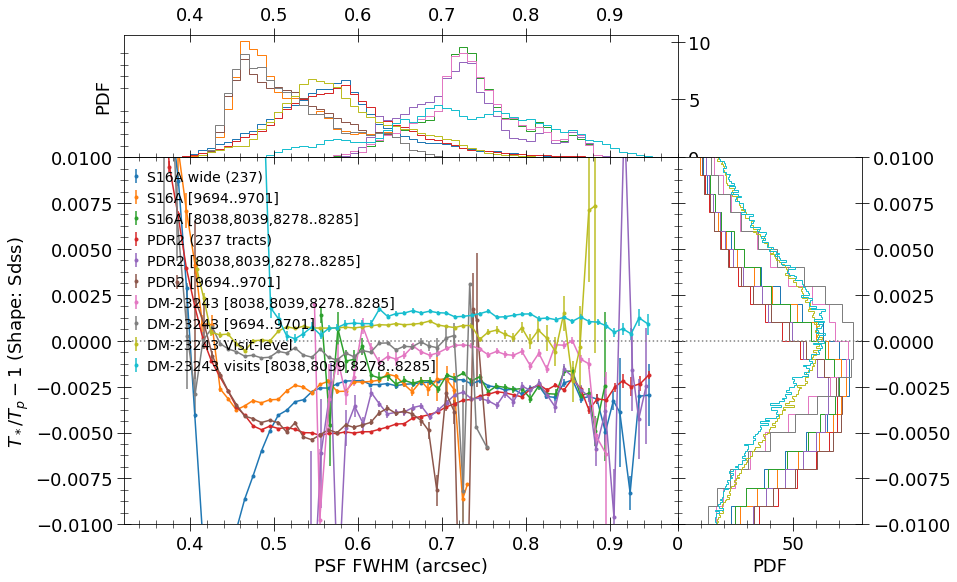

In [34]:
#s16a_wide.names
side_histograms=True
shape='Sdss'
figax = None
bins = np.arange(0.35,0.96,0.01)
bins2 = np.arange(-0.02,0.03,0.001)
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A wide (237)')
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']&(s16a_wide['tract']>=9694)&(s16a_wide['tract']<=9701)], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A [9694..9701]')

tract_cuts = (s16a_wide['tract']==8038) | (s16a_wide['tract']==8039) | (s16a_wide['tract']>=8278)&(s16a_wide['tract']<=8285)
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A [8038,8039,8278..8285]')

if shape!='HSM':
    figax = plotBob(pdr2[pdr2['i_calib_psfused']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 (237 tracts)')

    tract_cuts = (pdr2['tract']==8038) | (pdr2['tract']==8039) | (pdr2['tract']>=8278)&(pdr2['tract']<=8285)
    figax = plotBob(pdr2[pdr2['i_calib_psfused']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 [8038,8039,8278..8285]')

    tract_cuts = (pdr2['tract']>=9694)&(pdr2['tract']<=9701)
    figax = plotBob(pdr2[pdr2['i_calib_psfused']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 [9694..9701]')

figax = plotBob(new_tract_star_catalog[new_tract_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 [8038,8039,8278..8285]')
figax = plotBob(my_tract_star_catalog[my_tract_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 [9694..9701]')
bins2 = np.arange(-0.02,0.03,0.0001)
figax = plotBob(new_visit_star_catalog[new_visit_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 Visit-level')
figax = plotBob(visit_star_catalog_badseeing[visit_star_catalog_badseeing['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 visits [8038,8039,8278..8285]')
if side_histograms:
    fig, [ax_top, none, ax, ax_right] = figax
    ax_right.axhline(0.0, color='gray',ls=':')
else:
    fig, ax = figax
ax.axhline(0.0,color='gray',ls=':')
if side_histograms:
    ax.set_ylim([-0.01,0.01]); ax_right.set_ylim([-0.01,0.01])
    ax.legend(loc='best')
else:
    ax.set_ylim([-0.01,0.005])
    
ax.set_xlabel('PSF FWHM (arcsec)')
ax.set_ylabel(r'$T_*/T_p -1$ (Shape: {})'.format(shape))
ax_top.set_ylabel('PDF'); ax_right.set_xlabel('PDF')
ax_right.tick_params(labelright=True)
#ax.legend(loc='best')

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater_equal
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in less
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in sqrt


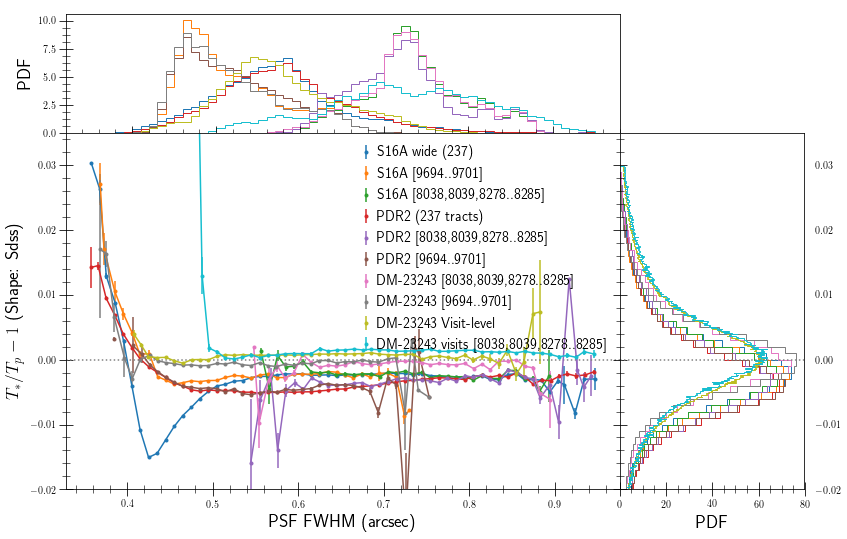

In [322]:
#s16a_wide.names
side_histograms=True
shape='Sdss'
figax = None
bins = np.arange(0.35,0.96,0.01)
bins2 = np.arange(-0.02,0.03,0.001)
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A wide (237)')
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']&(s16a_wide['tract']>=9694)&(s16a_wide['tract']<=9701)], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A [9694..9701]')

tract_cuts = (s16a_wide['tract']==8038) | (s16a_wide['tract']==8039) | (s16a_wide['tract']>=8278)&(s16a_wide['tract']<=8285)
figax = plotBob(s16a_wide[s16a_wide['icalib_psf_used']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='S16A [8038,8039,8278..8285]')

if shape!='HSM':
    figax = plotBob(pdr2[pdr2['i_calib_psfused']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 (237 tracts)')

    tract_cuts = (pdr2['tract']==8038) | (pdr2['tract']==8039) | (pdr2['tract']>=8278)&(pdr2['tract']<=8285)
    figax = plotBob(pdr2[pdr2['i_calib_psfused']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 [8038,8039,8278..8285]')

    tract_cuts = (pdr2['tract']>=9694)&(pdr2['tract']<=9701)
    figax = plotBob(pdr2[pdr2['i_calib_psfused']&tract_cuts], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='PDR2 [9694..9701]')

figax = plotBob(new_tract_star_catalog[new_tract_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 [8038,8039,8278..8285]')
figax = plotBob(my_tract_star_catalog[my_tract_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 [9694..9701]')
bins2 = np.arange(-0.02,0.03,0.0001)
figax = plotBob(new_visit_star_catalog[new_visit_star_catalog['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 Visit-level')
figax = plotBob(visit_star_catalog_badseeing[visit_star_catalog_badseeing['calib_psf_used']], shape=shape, bins=bins, bins2=bins2, figax=figax, side_histograms=side_histograms, label='DM-23243 visits [8038,8039,8278..8285]')
if side_histograms:
    fig, [ax_top, none, ax, ax_right] = figax
    ax_right.axhline(0.0, color='gray',ls=':')
else:
    fig, ax = figax
ax.axhline(0.0,color='gray',ls=':')
if side_histograms:
    ax.set_ylim([-0.02,0.035]); ax_right.set_ylim([-0.02,0.035])
    ax.legend(loc='best')
else:
    ax.set_ylim([-0.01,0.005])
    
ax.set_xlabel('PSF FWHM (arcsec)')
ax.set_ylabel(r'$T_*/T_p -1$ (Shape: {})'.format(shape))
ax_top.set_ylabel('PDF'); ax_right.set_xlabel('PDF')
ax_right.tick_params(labelright='on')
#ax.legend(loc='best')

In [327]:
print(Counter(s16a_wide['iflags_pixel_edge'][s16a_wide['icalib_psf_used']&(s16a_wide['tract']>=9694)&(s16a_wide['tract']<=9701)]))
tract_cuts = (pdr2['tract']>=9694)&(pdr2['tract']<=9701)
print(Counter(pdr2['i_pixelflags_edge'][pdr2['i_calib_psfused']&tract_cuts]))
print(Counter(my_tract_star_catalog['base_PixelFlags_flag_edge'][my_tract_star_catalog['calib_psf_used']]))

Counter({False: 243296, True: 1502})
Counter({False: 275004, True: 2375})
Counter({False: 275731, True: 2302})


/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log10


295
96
96
1683
546
546
1409
343
343


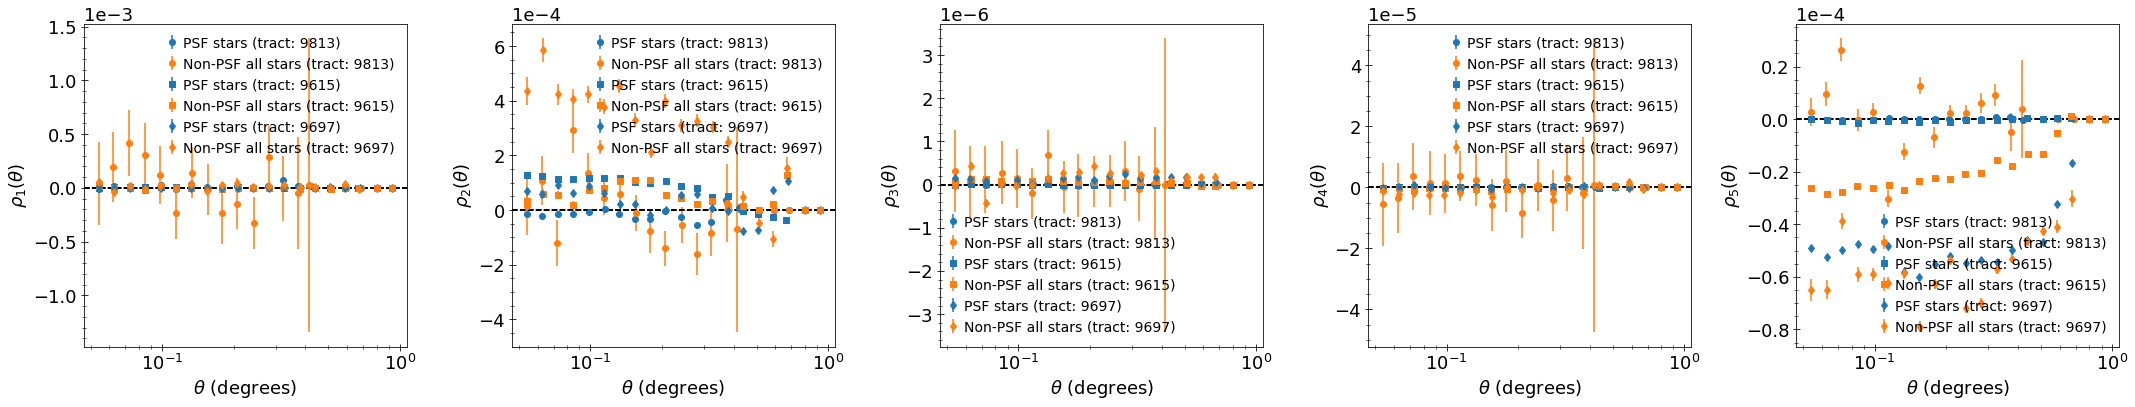

In [90]:
tracts = [9813,9615,9697]
markers = ['o','s','d']
#tract_star_catalog_list = [getStarCatalog(tracts=[tract]) for tract in tracts]
fig, ax = plt.subplots(1,5)
fig.set_size_inches([30,6])
for tract_index, tract_star_cat in enumerate(tract_star_catalog_list):
    tract = tracts[tract_index]
    plotAll(tract_star_cat, yscale='linear', figax=(fig,ax), from_scratch=True, marker=markers[tract_index], label_suffix=' (tract: {0})'.format(tract))

In [21]:
visit_star_catalog = myButler(visits=True)

3131269
4389666
2628240


4413463
24760229
24760229


(<Figure size 2160x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dd85ddb00>,
       dtype=object))

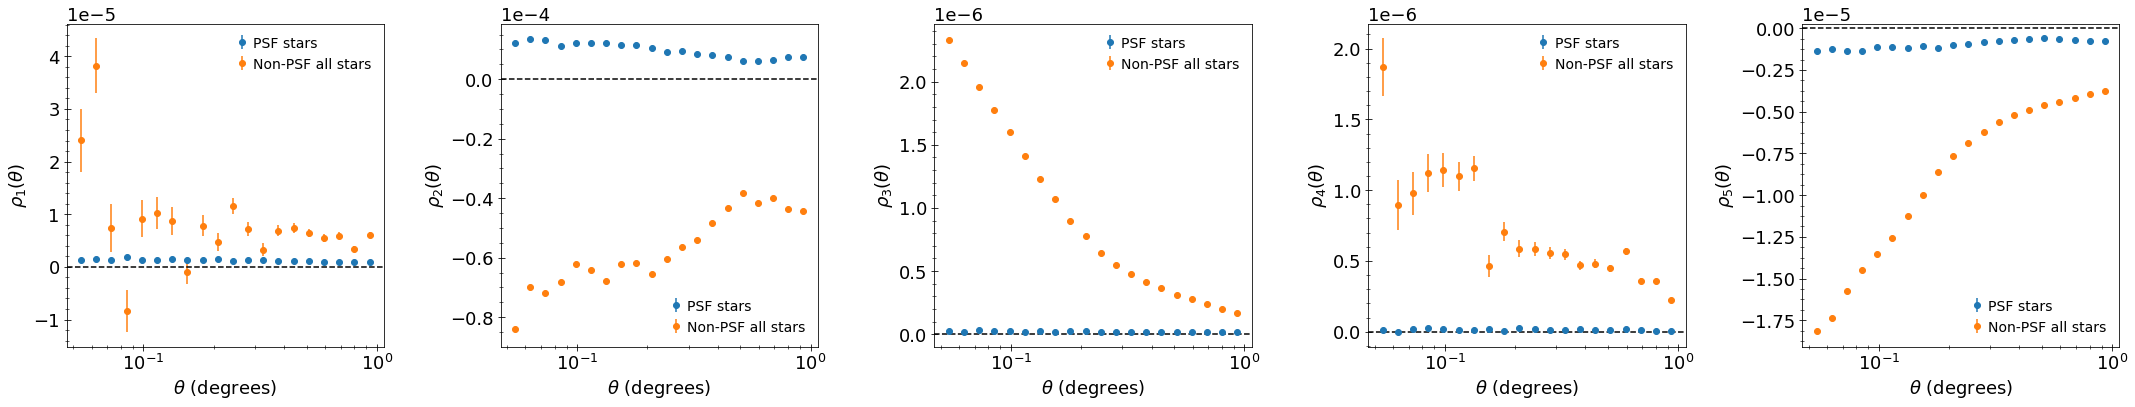

In [19]:
plotAll(s16a_wide, yscale='linear',from_scratch=True)

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log10


3387
985
985


(<Figure size 2160x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d861900f0>,
       dtype=object))

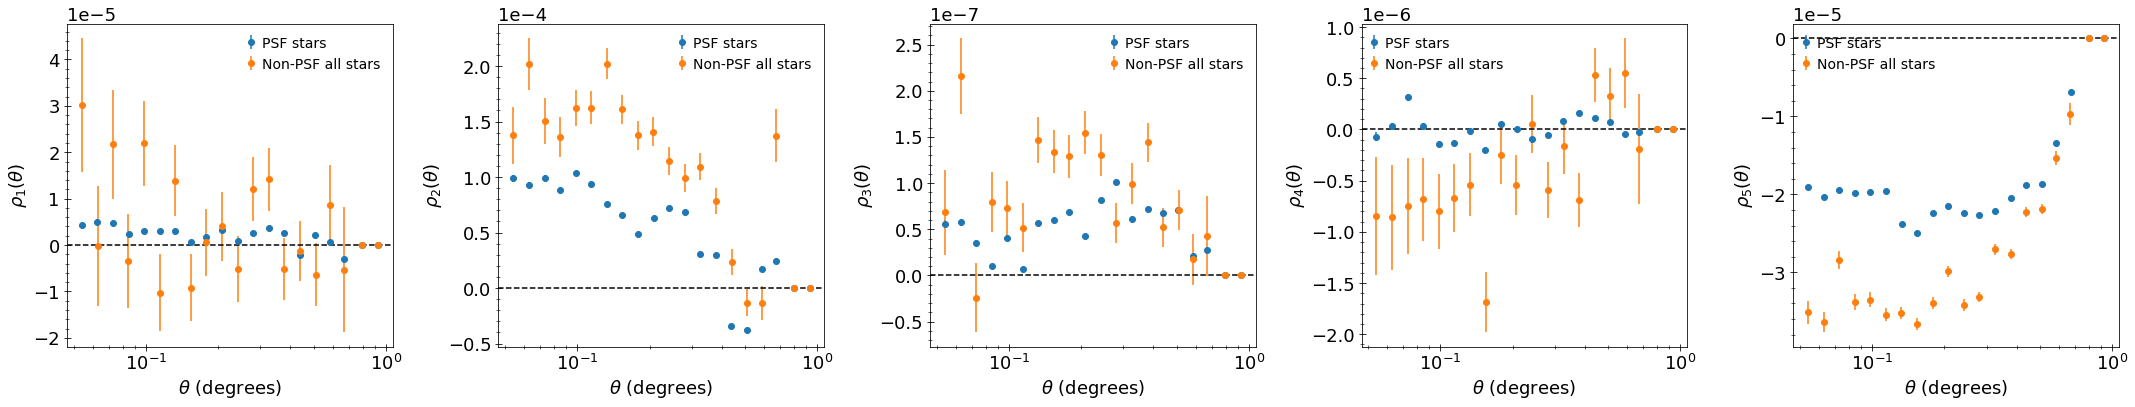

In [89]:
plotAll(tract_star_catalog, yscale='linear',from_scratch=True)

In [28]:
star_catalog = tract_star_catalog
print(star_catalog['calib_psf_used'].dtype, star_catalog['base_ClassificationExtendedness_value'].dtype, star_catalog['base_PixelFlags_flag_interpolated'].dtype, star_catalog['base_PixelFlags_flag_cr'].dtype, star_catalog['base_PixelFlags_flag_saturated'].dtype, star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'].dtype, star_catalog['ext_shapeHSM_HsmSourceMoments_flag'].dtype, star_catalog['ext_shapeHSM_HsmPsfMoments_flag'].dtype, star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'].dtype)



##star_catalog['calib_psf_used'].dte, star_catalog['base_ClassificationExtendedness_value'].dtype, star_catalog['base_PixelFlags_flag_interpolated'].dtype, star_catalog['base_PixelFlags_flag_cr'].dtype, star_catalog['base_PixelFlags_flag_saturated'].dtype, star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid'])

bool float64 bool bool bool bool bool bool bool


In [239]:
len(set(s16a_wide['visit']))

237

In [91]:
plotAll(visit_star_catalog, yscale='linear',from_scratch=True)

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0


RuntimeError: Catalog has no objects!

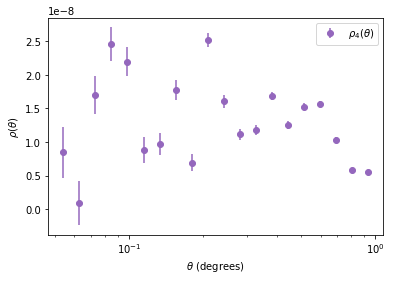

In [66]:
star_catalog = s16a_wide
fig, ax = plt.subplots()
shape = 'HSM'
xscale, yscale = 'log', 'linear'
title = None
compareCol = 'ext_shapeHSM_HsmSourceMoments'
psfCompareCol = 'ext_shapeHSM_HsmPsfMoments'
rhoStatsFunc = RhoStatistics(compareCol, psfCompareCol)

if False:
    omit = star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] 
    omit = omit | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid']
    star_catalog = star_catalog[~omit]

    fname = 'psfStars_'+shape
    
    cuts = star_catalog['calib_psf_used']==1
    input_catalog = star_catalog[cuts]
    rhoStats = rhoStatsFunc(input_catalog, fname=fname)

for rhoIndex in [4]:
    rhoStats = ascii.read('rho{}_'.format(rhoIndex)+fname)
    ## The mapping creates plots as in DES papers
    #ax = axes[1] if rhoIndex in [2,5] else axes[0]
    colorStr = "C{}".format(rhoIndex) # + str(np.mod(iTract, 9))
    isPositive = rhoStats['xip'][rhoIndex]>0

    ax.errorbar(rhoStats['meanR'], rhoStats['xip'], yerr=rhoStats['sigma_xi'], color=colorStr,
            fmt='o', label=r"$\rho_{0}(\theta)$".format(rhoIndex))
    #ax.plot(rhoStats['meanR'], (0.00001)*rhoStats['meanR'])
        
if yscale=='symlog':
    ax.set_yscale('symlog', linthresy=0.000000001)
else:
    ax.set_yscale(yscale)
ax.set_xscale(xscale)
ax.set_ylabel(r'$\rho(\theta)$')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_title(title)
ax.legend(loc=1)

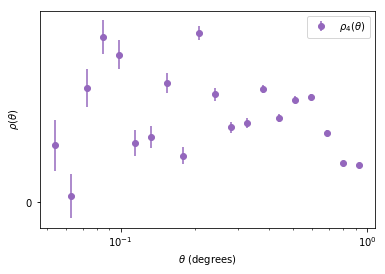

In [67]:
star_catalog = s16a_wide
fig, ax = plt.subplots()
shape = 'HSM'
xscale, yscale = 'log', 'symlog'
title = None
compareCol = 'ext_shapeHSM_HsmSourceMoments'
psfCompareCol = 'ext_shapeHSM_HsmPsfMoments'
rhoStatsFunc = RhoStatistics(compareCol, psfCompareCol)

if False:
    omit = star_catalog['base_PixelFlags_flag_interpolated'] | star_catalog['base_PixelFlags_flag_cr'] | star_catalog['base_PixelFlags_flag_saturated'] 
    omit = omit | star_catalog['ext_shapeHSM_HsmSourceMoments_flag_badCentroid'] | star_catalog['ext_shapeHSM_HsmSourceMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag'] | star_catalog['ext_shapeHSM_HsmPsfMoments_flag_badCentroid']
    star_catalog = star_catalog[~omit]

    fname = 'psfStars_'+shape
    
    cuts = star_catalog['calib_psf_used']==1
    input_catalog = star_catalog[cuts]
    rhoStats = rhoStatsFunc(input_catalog, fname=fname)

for rhoIndex in [4]:
    rhoStats = ascii.read('rho{}_'.format(rhoIndex)+fname)
    ## The mapping creates plots as in DES papers
    #ax = axes[1] if rhoIndex in [2,5] else axes[0]
    colorStr = "C{}".format(rhoIndex) # + str(np.mod(iTract, 9))
    isPositive = rhoStats['xip'][rhoIndex]>0

    ax.errorbar(rhoStats['meanR'], rhoStats['xip'], yerr=rhoStats['sigma_xi'], color=colorStr,
            fmt='o', label=r"$\rho_{0}(\theta)$".format(rhoIndex))
    #ax.plot(rhoStats['meanR'], (0.00001)*rhoStats['meanR'])
        
if yscale=='symlog':
    ax.set_yscale('symlog', linthresy=0.000000001)
else:
    ax.set_yscale(yscale)
ax.set_xscale(xscale)
ax.set_ylabel(r'$\rho(\theta)$')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_title(title)
ax.legend(loc=1)

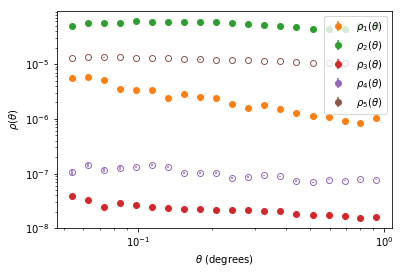

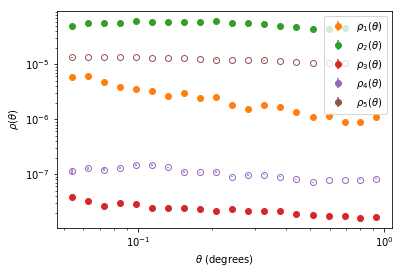

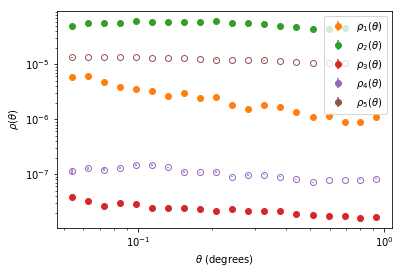

In [337]:
plotAll(tract_star_catalog)

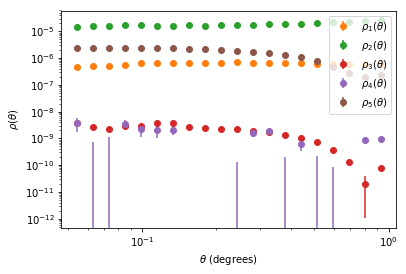

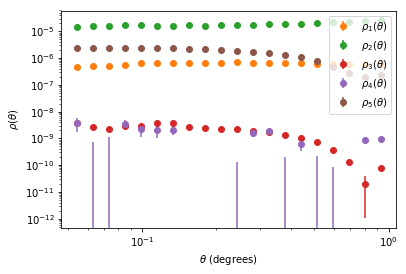

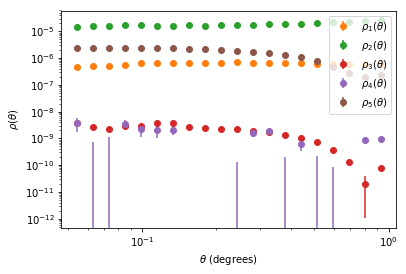

In [338]:
plotAll(visit_star_catalog, shape='HSM', yscale='log')

In [194]:
flags = ["base_SdssShape_flag", "base_SdssShape_flag_psf"]

compareCol = 'base_SdssShape'
psfCompareCol = 'base_SdssShape_psf'
rhoStatsFunc = RhoStatistics(compareCol, psfCompareCol)

In [7]:
s16a_wide['ext_shapeHSM_HsmSourceMoments_flag_badCentroid']

0           False
1           False
2           False
3           False
4           False
            ...  
37634511    False
37634512    False
37634513    False
37634514    False
37634515    False
Name: ext_shapeHSM_HsmSourceMoments_flag_badCentroid, Length: 37634516, dtype: bool

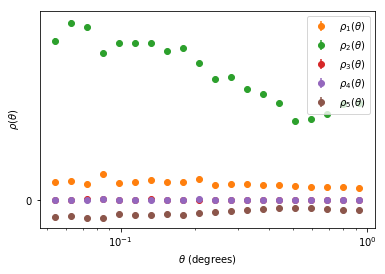

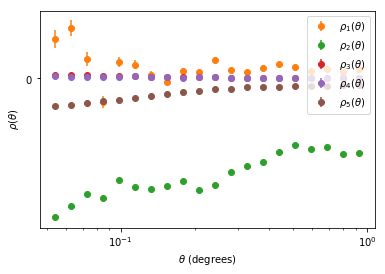

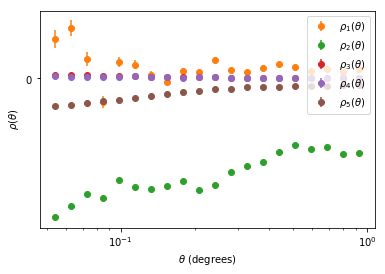

In [43]:
cuts = (s16a_wide['ext_shapeHSM_HsmSourceMoments_flag']==0)&(s16a_wide['ext_shapeHSM_HsmPsfMoments_flag']==0)
plotAll(s16a_wide[cuts], yscale='symlog', from_scratch=False)

In [26]:
Counter(s16a_wide['ishape_hsm_psfmoments_flags'])

KeyError: 'ishape_hsm_psfmoments_flags'

In [ ]:
visit_star_catalog = myButler(visits=True)

3131269
2532036
4389666
3148679


In [ ]:
#tract_star_catalog = myButler(visits=False)
tract_star_catalog = getStarCatalog()

In [263]:
np.sum((tract_star_catalog['base_SdssShape_flag']==0)&(tract_star_catalog['base_SdssShape_flag_psf']==0))

62344

In [23]:
tract_star_catalog

id,coord_ra,coord_dec,parent,merge_footprint_i2,merge_footprint_i,merge_footprint_r2,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_N921,merge_footprint_N816,merge_footprint_N1010,merge_footprint_N387,merge_footprint_N515,merge_footprint_sky,merge_peak_i2,merge_peak_i,merge_peak_r2,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_N921,merge_peak_N816,merge_peak_N1010,merge_peak_N387,merge_peak_N515,merge_peak_sky,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_InputCount_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_3_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_InputCount_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_0_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_1_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_2_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_3_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,modelfit_DoubleSha

64626 811034


(0.01, 0.06)

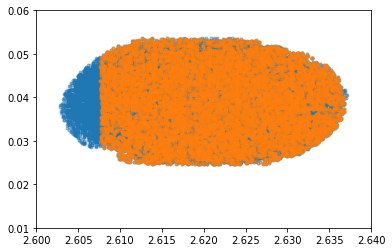

In [211]:
print(len(tract_star_catalog), len(visit_star_catalog))
plt.scatter(visit_star_catalog['coord_ra'], visit_star_catalog['coord_dec'],marker='.',alpha=0.4)
plt.scatter(tract_star_catalog['coord_ra'], tract_star_catalog['coord_dec'],marker='.',alpha=0.4)
plt.xlim([2.60,2.64])
plt.ylim([0.01,0.06])

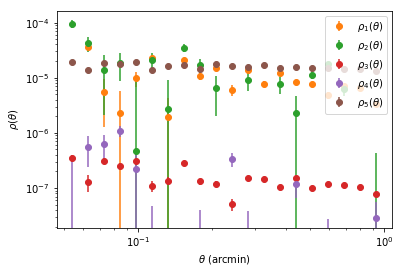

In [203]:
cuts = (tract_star_catalog['calib_psf_used']==1)&(tract_star_catalog['base_SdssShape_flag']==0)&(tract_star_catalog['base_SdssShape_flag_psf']==0)
star_catalog = tract_star_catalog[cuts]
rhoStats = rhoStatsFunc(star_catalog, fname='test')
rhoStat = rhoStats[2]
fig, ax = plt.subplots()
plot('test', [ax], yscale='log')
ax.set_xscale('log')

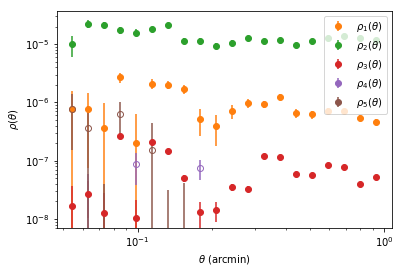

In [206]:
cuts = (visit_star_catalog['calib_psf_used']==1)&(visit_star_catalog['base_SdssShape_flag']==0)&(visit_star_catalog['base_SdssShape_flag_psf']==0)
star_catalog = visit_star_catalog[cuts]
rhoStats = rhoStatsFunc(star_catalog, fname='test')
rhoStat = rhoStats[2]
fig, ax = plt.subplots()
plot('test', [ax], yscale='log')
ax.set_xscale('log')

In [207]:
inp = ascii.read('rho2_test')
inp['npairs'].sum()

233780740.0

TypeError: can only concatenate str (not "dict") to str

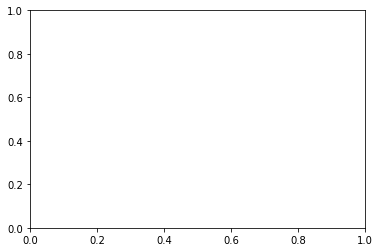

In [178]:
fig, ax = plt.subplots()
plot(rhoStats, [ax])

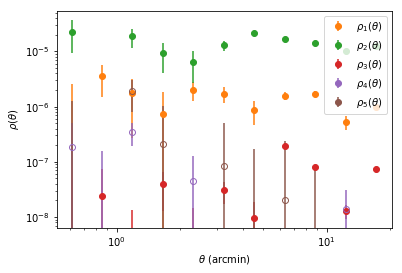

In [179]:
fig, ax = plt.subplots()
plot('test', [ax], yscale='log')

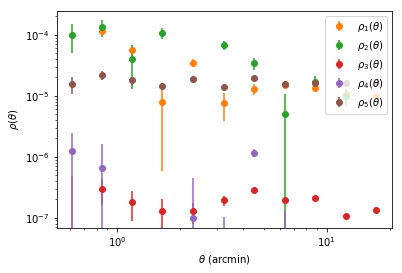

In [189]:
fig, ax = plt.subplots()
plot('test', [ax], yscale='log')

In [217]:
patch_data = fits.open('/datasets/hsc/repo/rerun/RC/w_2019_38/DM-21386/deepCoadd-results/HSC-I/9697/4,4/meas-HSC-I-9697-4,4.fits')[1].data
patch_data.names

['flags',
 'id',
 'coord_ra',
 'coord_dec',
 'parent',
 'deblend_nChild',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psf_instFlux',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_Blendedness_old',
 'base_Blendedness_raw',
 'base_Blendedness_raw_child_instFlux',
 'base_Blendedness_raw_parent_instFlux',
 'base_Blendedness_abs',
 'base_Blendedness_abs_child_instFlux',
 'base_Blendedness_abs_parent_instFlux',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_yy',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_abs_parent_xy',
 'base_InputCount_value',
 'base_SdssShape_xx',
 '

In [267]:
np.nanmax(tract_star_catalog['base_ClassificationExtendedness_value'][tract_star_catalog['calib_psf_used']==1])

0.0

In [138]:
[colname for colname in list(new_visit_star_catalog.columns) if 'size' in colname.lower() ]

[]

In [12]:
[idx for idx in list(tract_star_catalog.columns) if 'edge' in idx and 'flag' in idx]

['base_NaiveCentroid_flag_edge',
 'base_SdssCentroid_flag_edge',
 'base_CircularApertureFlux_flag_badCentroid_edge',
 'base_GaussianFlux_flag_badCentroid_edge',
 'base_InputCount_flag_badCentroid_edge',
 'base_LocalBackground_flag_badCentroid_edge',
 'base_NaiveCentroid_flag_badInitialCentroid_edge',
 'base_PsfFlux_flag_badCentroid_edge',
 'base_SdssShape_flag_badCentroid_edge',
 'base_Variance_flag_badCentroid_edge',
 'ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge',
 'ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge',
 'ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge',
 'ext_convolved_ConvolvedFlux_3_flag_badCentroid_edge',
 'ext_convolved_ConvolvedFlux_flag_badCentroid_edge',
 'ext_photometryKron_KronFlux_flag_badInitialCentroid_edge',
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge',
 'ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge',
 'ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge',
 'ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge',
 'modelfit_Dou

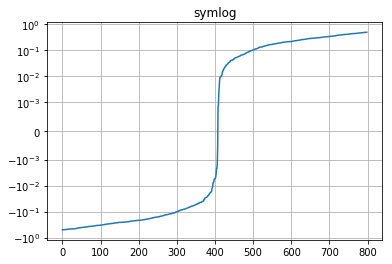

In [39]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
fig, ax = plt.subplots()
#plt.figure(1)
#plt.subplot(223)
ax.errorbar(x, y - y.mean())
ax.set_yscale('symlog', linthreshy=0.001)
ax.set_title('symlog')
ax.grid(True)

In [58]:
[idx for idx in list(s16a_wide.columns) ]

['# object_id',
 'coord_ra',
 'coord_dec',
 'ext_shapeHSM_HsmPsfMoments_xx',
 'ext_shapeHSM_HsmPsfMoments_yy',
 'ext_shapeHSM_HsmPsfMoments_xy',
 'ext_shapeHSM_HsmSourceMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_yy',
 'ext_shapeHSM_HsmSourceMoments_xy',
 'ext_shapeHSM_HsmSourceMoments_flag',
 'ext_shapeHSM_HsmPsfMoments_flag',
 'ext_shapeHSM_HsmSourceMoments_flag_badCentroid',
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid',
 'icalib_psf_candidate',
 'calib_psf_used',
 'iflags_negative',
 'iflags_pixel_edge',
 'iflags_badcentroid',
 'base_PixelFlags_flag_interpolated',
 'iflags_pixel_interpolated_center',
 'base_PixelFlags_flag_saturated',
 'iflags_pixel_saturated_center',
 'base_PixelFlags_flag_cr',
 'iflags_pixel_cr_center',
 'iflags_pixel_bad',
 'iflags_pixel_suspect_any',
 'iflags_pixel_suspect_center',
 'iflags_pixel_suspect_any.1',
 'iflags_pixel_suspect_center.1',
 'iflags_pixel_clipped_any',
 'base_ClassificationExtendedness_value']